# Creación de un modelo inicial

In [ ]:
%pip install ucimlrepo
#%pip install scikit-learn
#%pip install pandas
#%pip install matplotlib
#%pip install seaborn
#%pip install -U imbalanced-learn

## Carga, transformacion y preparacion de datos

### Carga de los datos

Obtenemos el dataset de para el modelo.

In [1]:
from ucimlrepo import fetch_ucirepo

# Descargar dataset con ID 144
statlog_german_credit_data = fetch_ucirepo(id=144)

# Guardar todo el dataset en un DataFrame
df = statlog_german_credit_data.data.original

# Mostrar las 5 primeras filas
df.head(1)

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1


In [3]:
df = df.rename(columns={
    'Attribute1': 'estado_cuenta',               # Categorical
    'Attribute2': 'duracion_meses',              # Integer
    'Attribute3': 'historial_credito',           # Categorical
    'Attribute4': 'proposito',                    # Categorical
    'Attribute5': 'monto_credito',                # Integer
    'Attribute6': 'cuenta_ahorro_bonos',         # Categorical
    'Attribute7': 'empleo_actual',                # Categorical
    'Attribute8': 'tasa_cuota_ingreso',           # Integer
    'Attribute9': 'estado_civil_sexo',            # Categorical
    'Attribute10': 'otros_deudores_garantes',    # Categorical
    'Attribute11': 'residencia_actual_anios',    # Integer
    'Attribute12': 'propiedad',                    # Categorical
    'Attribute13': 'edad',                         # Integer
    'Attribute14': 'otros_planes_cuotas',         # Categorical
    'Attribute15': 'vivienda',                     # Categorical
    'Attribute16': 'num_creditos_banco',           # Integer
    'Attribute17': 'ocupacion',                    # Categorical
    'Attribute18': 'num_personas_a_cargo',         # Integer
    'Attribute19': 'telefono',                      # Binary
    'Attribute20': 'trabajador_extranjero',         # Binary
    'class': 'buen_mal_credito'                    # Binary (Target)
})

df.head(3)

,estado_cuenta,duracion_meses,historial_credito,proposito,monto_credito,cuenta_ahorro_bonos,empleo_actual,tasa_cuota_ingreso,estado_civil_sexo,otros_deudores_garantes,...,propiedad,edad,otros_planes_cuotas,vivienda,num_creditos_banco,ocupacion,num_personas_a_cargo,telefono,trabajador_extranjero,buen_mal_credito
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


Agregamos la columna grupo etario

In [4]:
df['grupo_etario'] = '' 

df.loc[df['edad'] < 20, 'grupo_etario'] = '<20'
df.loc[(df['edad'] >= 20) & (df['edad'] < 30), 'grupo_etario'] = '20-29'
df.loc[(df['edad'] >= 30) & (df['edad'] < 40), 'grupo_etario'] = '30-39'
df.loc[(df['edad'] >= 40) & (df['edad'] < 50), 'grupo_etario'] = '40-49'
df.loc[(df['edad'] >= 50) & (df['edad'] < 60), 'grupo_etario'] = '50-59'
df.loc[(df['edad'] >= 60) & (df['edad'] < 70), 'grupo_etario'] = '60-69'
df.loc[(df['edad'] >= 70) & (df['edad'] < 80), 'grupo_etario'] = '70-79'
df.loc[df['edad'] >= 80, 'grupo_etario'] = '+80'

### Transformacion de datos

Primero vamos a separar el estado el atributo combinado estado_civil_sexo, en 2 nuevas columnas, tenemos estos valores de esa columna:

In [5]:
print(df['estado_civil_sexo'].unique())
print('-'*30)
print(df['estado_civil_sexo'].value_counts())

['A93' 'A92' 'A91' 'A94']
------------------------------
estado_civil_sexo
A93    548
A92    310
A94     92
A91     50
Name: count, dtype: int64


#### Personal status and sex

* A91 : male   : divorced/separated
* A92 : female : divorced/separated/married
* A93 : male   : single
* A94 : male   : married/widowed
* A95 : female : single

In [7]:
map_sexo = {
    'A91': 'male',
    'A92': 'female',
    'A93': 'male',
    'A94': 'male',
    'A95': 'female'
}

map_estado_balanceado = {
    'A91': 'not_single',
    'A92': 'not_single',
    'A93': 'single',
    'A94': 'not_single',
    'A95': 'single'
}

Creamos las nuevas columnas

In [8]:
df['estado_civil'] = df['estado_civil_sexo'].map(map_estado_balanceado)
df['sexo'] = df['estado_civil_sexo'].map(map_sexo)


In [9]:
print(df['estado_civil'].value_counts())
print("-"*30)
print(df['sexo'].value_counts())

estado_civil
single        548
not_single    452
Name: count, dtype: int64
------------------------------
sexo
male      690
female    310
Name: count, dtype: int64


In [10]:
# Eliminamos nuestra columna: 'estado_civil_sexo'
df.drop('estado_civil_sexo', axis=1, inplace=True)

### Preparando datos para entrenar

En primer lugar, vamos a transformar el dataset utilizando one-hot encoding para que el clasificador pueda procesarlo correctamente. En un principio, consideramos interpretar algunas variables como ordinales para reducir la cantidad de columnas generadas, pero finalmente decidimos no hacerlo.

Aunque muchas categorías tienen un orden lógico y sus descripciones reflejan los límites entre ellas, el tipo de clasificador que elegimos — árboles de decisión — tiende a interpretar estas categorías ordinales como si unas fueran mejores que otras. 

Queríamos evitar introducir un sesgo de etiqueta artificial en el modelo, por lo que preferimos tratarlas como variables categóricas sin orden implícito. De esta manera, no se asume que una categoría es superior o inferior a otra.

Primero aplicamos encoding a los features

In [11]:
import pandas as pd
features = df.drop('buen_mal_credito', axis=1)
features_encoded = pd.get_dummies(features, dtype=int)

Separando features y target

In [12]:
X = features_encoded
Y = df['buen_mal_credito']

## Eleccion del modelo de clasificación

Como modelo de clasificación, elegimos Random Forest porque consideramos que es el método más efectivo para este tipo de datos. Este modelo es capaz de capturar relaciones no lineales complejas, por lo que nos pareció adecuado evitar modelos que puedan tener dificultades para manejar dicha complejidad.

Además, Random Forest maneja de forma eficiente las variables categóricas codificadas mediante one-hot encoding y es menos propenso al sobreajuste gracias a su naturaleza basada en múltiples árboles y técnicas de bagging.

Para utilizar Random Forest, es necesario transformar las columnas categóricas. En nuestro caso, aplicamos one-hot encoding porque las variables no son ordinales, y queremos evitar que el clasificador interprete un orden que no existe entre las categorías.

## Entrenamiento y evaluación del modelo

Separando los datos para entrenamiento y prueba

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=27, stratify=Y) 

### Modelo 1 Random Forest Simple

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=17, stratify=Y) 

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Definir el modelo base
modelo = RandomForestClassifier(random_state=13)
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted')
}

# Definir espacio de hiperparámetros para GridSearch
param_grid = {
    'n_estimators': [15, 20, 50, 100],
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    scoring=scoring,
    refit='accuracy',  # El criterio para elegir el mejor modelo y refit
    cv=5,
    n_jobs=-1
)


# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo
best_clf = grid_search.best_estimator_

# Entrenar el mejor modelo con todo el conjunto de entrenamiento
best_clf.fit(X_train, y_train)

# Predecir en conjunto de prueba
y_pred = best_clf.predict(X_test)

# Calcular métricas clásicas para multiclase
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Mejores hiperparámetros: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
Accuracy: 0.8000
Precision: 0.7967
Recall: 0.8000
F1-score: 0.7829


#### Matriz de confusión

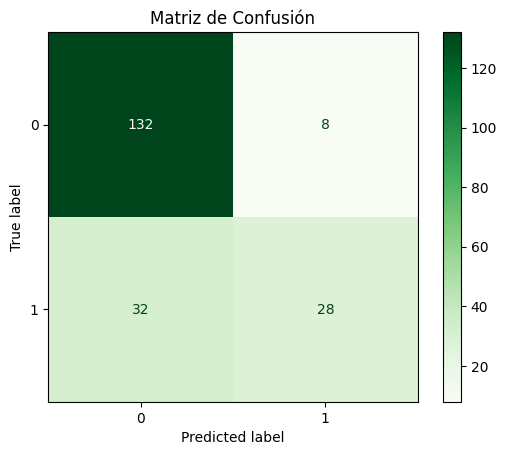

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predecir en conjunto de prueba
y_pred = best_clf.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión con etiquetas y colores
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Matriz de Confusión')
plt.show()


### Modelo 2 L1-Regularized Logistic Regression Pipeline

In [72]:
from sklearn.preprocessing import StandardScaler  # ¡Corrige la importación!
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

poly_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'))  # Añade max_iter y solver
])

param_grid2 = {
    'logreg__C': [0.00001, 0.001, 0.1, 0.99, 10, 100, 1000000],
    'logreg__class_weight': ['balanced', None],  # ¡Cambia 'dict' por 'balanced'!
    'logreg__solver': ['liblinear', 'saga']
}

grid_search2 = GridSearchCV(
    estimator=poly_reg_pipeline,
    param_grid=param_grid2,
    cv=4,
    scoring='f1_weighted',
    n_jobs=-1
)

grid_search2.fit(X_train, y_train)


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1e-05, 0.001, 0.1, 0.99, 10, 100,
                                       1000000],
                         'logreg__class_weight': ['balanced', None],
                         'logreg__solver': ['liblinear', 'saga']},
             scoring='f1_weighted')

In [73]:
grid_search2.best_params_

{'logreg__C': 100, 'logreg__class_weight': None, 'logreg__solver': 'liblinear'}

In [74]:
grid_search2.best_score_

np.float64(0.7401749714505704)

In [75]:
# Obtener el mejor modelo de la búsqueda
best_lr_model_rel = grid_search2.best_estimator_

# Obtener el modelo de regresión logística específico del pipeline
logreg_model = best_lr_model_rel.named_steps['logreg']

# Obtener los coeficientes y el nombre de las columnas originales
coefficients_rel = logreg_model.coef_
columnas = X.columns

# Crear un DataFrame con los coeficientes y las columnas correspondientes
coeficientes_df = pd.DataFrame(data=coefficients_rel, columns=columnas)

# Configurar pandas para mostrar todas las columnas y filas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Imprimir el DataFrame
display(coeficientes_df)


,duracion_meses,monto_credito,tasa_cuota_ingreso,residencia_actual_anios,edad,num_creditos_banco,num_personas_a_cargo,estado_cuenta_A11,estado_cuenta_A12,estado_cuenta_A13,estado_cuenta_A14,historial_credito_A30,historial_credito_A31,historial_credito_A32,historial_credito_A33,historial_credito_A34,proposito_A40,proposito_A41,proposito_A410,proposito_A42,proposito_A43,proposito_A44,proposito_A45,proposito_A46,proposito_A48,proposito_A49,cuenta_ahorro_bonos_A61,cuenta_ahorro_bonos_A62,cuenta_ahorro_bonos_A63,cuenta_ahorro_bonos_A64,cuenta_ahorro_bonos_A65,empleo_actual_A71,empleo_actual_A72,empleo_actual_A73,empleo_actual_A74,empleo_actual_A75,otros_deudores_garantes_A101,otros_deudores_garantes_A102,otros_deudores_garantes_A103,propiedad_A121,propiedad_A122,propiedad_A123,propiedad_A124,otros_planes_cuotas_A141,otros_planes_cuotas_A142,otros_planes_cuotas_A143,vivienda_A151,vivienda_A152,vivienda_A153,ocupacion_A171,ocupacion_A172,ocupacion_A173,ocupacion_A174,telefono_A191,telefono_A192,trabajador_extranjero_A201,trabajador_extranjero_A202,grupo_etario_20-29,grupo_etario_30-39,grupo_etario_40-49,grupo_etario_50-59,grupo_etario_60-69,grupo_etario_70-79,grupo_etario_<20,estado_civil_not_single,estado_civil_single,sexo_female,sexo_male
0,0.345109,0.478534,0.490912,-0.031618,-0.238812,0.076106,0.16894,0.323766,0.165932,-0.201535,-0.531738,0.105768,0.14727,0.078938,-0.039895,-0.235674,0.33913,-0.269903,-0.103367,0.0,-0.151826,0.07171,0.038715,0.189587,-0.805233,0.078177,0.295596,0.08085,0.013631,-0.149298,-0.177414,0.0,0.039043,0.026648,-0.259811,-0.002099,0.0,0.051335,-0.168906,-0.164468,0.092166,-0.014193,0.202775,0.075656,0.0,-0.253014,0.100254,-0.076298,-0.150669,-0.08741,0.043368,0.0,-0.08681,0.165021,-0.088565,0.210474,-0.063847,0.0,-0.043995,0.008721,0.06952,0.202119,0.012159,0.0,0.071623,-0.304983,-0.061431,0.089789


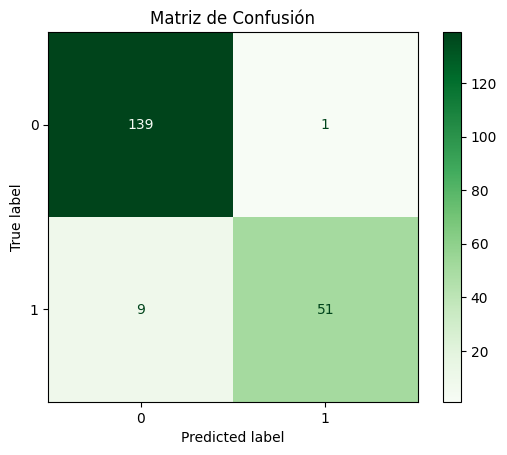

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predecir en conjunto de prueba
y_pred2 = best_clf.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred2)

# Mostrar la matriz de confusión con etiquetas y colores
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Matriz de Confusión')
plt.show()

In [77]:
# Calcular métricas clásicas para multiclase
accuracy = accuracy_score(y_test, y_pred2)
precision = precision_score(y_test, y_pred2, average='weighted')
recall = recall_score(y_test, y_pred2, average='weighted')
f1 = f1_score(y_test, y_pred2, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.9500
Precision: 0.9517
Recall: 0.9500
F1-score: 0.9489



La elección del modelo (**L1-Regularized Logistic Regression Pipeline**) se fundamenta principalmente en su excelente rendimiento evaluado a través de diversas métricas clave. 

## Interpretacion de resultados



El modelo **L1-Regularized Logistic Regression Pipeline** muestra un desempeño sobresaliente según las principales métricas de evaluación. 

* El **accuracy** es de **0.9500**, lo que indica que el modelo clasifica correctamente el 95% de los casos del conjunto de prueba. 
* La **precisión** alcanza **0.9517**, reflejando que comete muy pocos falsos positivos. 
* El **recall**, que evalúa la capacidad para identificar correctamente los casos positivos, también es de **0.9500**, lo que evidencia que el modelo detecta la mayoría de los casos que realmente corresponden a la clase positiva. 
* Por su parte, el **F1-score**, que equilibra precisión y recall, es de **0.9489**, reafirmando la solidez del modelo al clasificar ambas clases de manera balanceada.

Al observar la **matriz de confusión**, se destaca que el modelo predice correctamente:
* **139 verdaderos negativos** y **51 verdaderos positivos**.
* cometiendo solo **1 falso positivo** y **9 falsos negativos**. 

Esto significa que casi no clasifica incorrectamente como positivos a casos negativos, y que el número de positivos que no identifica es relativamente bajo.


## Justificacion

Si el banco que otorga los créditos tiene el objetivo institucional de **maximizar la cantidad de personas que efectivamente pagarán el préstamo**, el **error más perjudicial sería el falso negativo** (clasificar como “no paga” a alguien que sí pagaría). Sin embargo, en el contexto bancario, el error más crítico suele ser el **falso positivo**: otorgar crédito a alguien que no va a pagar, lo que representa una **pérdida económica directa** para la institución.

En este caso, el modelo comete solo **1 falso positivo**, un valor extremadamente bajo y favorable para el banco. Por tanto, si el objetivo es captar clientes que efectivamente pagarán sin asumir riesgos excesivos, este modelo ofrece un buen equilibrio. 

Aunque los falsos negativos pueden implicar perder posibles buenos clientes, los falsos positivos suponen un **riesgo financiero más importante**. Dado que ambos errores están bien controlados, y el falso positivo es especialmente bajo, el modelo se alinea con los intereses típicos de una institución financiera.

No obstante, si el banco priorizara exclusivamente captar a todos los buenos pagadores, entonces el falso negativo podría considerarse el error más costoso. Aun así, en la práctica, se busca **minimizar los falsos positivos** debido a su impacto económico.


# Evaluación de equidad del modelo inicial (3)

## Interpretacion de los criterios Fairness

En el contexto de la asignación de prestamos, después de ver los datos, consideramos como grupos de interés para buscar la equidad a las mujeres y los hombres, aunque también se podría considerar un grupo cada franja de edades. Siendo esos los grupos que nos interesan, en este contexto interpretamos los criterios de fairness de la siguiente manera: 

- *Statistical Parity*:
Este criterio se cumple si para todos los grupos la taza de predicciones positivas es la misma, lo que en este contexto significa que tanto para hombres como para mujeres se debería tener la misma probabilidad de conseguir que el modelo los clasifique como un buen credito y en consecuencia el banco les de el dinero.

- *Equalized Odds*:
En el caso de este criterio se busca que la probabilidad de que se apruebe el credito dado que era un buen credito y la probabilidad de que se apruebe el credito siendo que en la realidad era un mal credito sean las mismas entre los grupos. Esto se traduce en que se busca que para hombres y mujeres exista  la misma probabilidad de conseguir un prestamo dado que realmente es un buen credito, y la misma probabilidad de obtenerlo dado que no es un buen credito. Se espera que para las asignaciones de prestamos el modelo acierte y se equivoque con la misma taza entre grupos.

- *Equal Opportunity*:
Para este contexto implica que para hombres y mujeres exista la misma probabilidad de conseguir un préstamo dado que realmente es un buen credito. Solo mira los True Positive Rate. 

- *Predictive Parity*:
Este criterio se cumple cuando entre los grupos de interés la probabilidad de que en la realidad sea positivo dado que la predicción es positiva es la misma o similar. En el contexto de los prestamos se traduce buscando que si el modelo aprueba un credito, la probabilidad de que realmente sea un buen credito sea la misma tanto para mujeres como para hombres, es decir que la taza de prestamos aprobados correctamente sea similar.

## Analisis de Criterios

In [78]:
print(X_test)

     duracion_meses  monto_credito  tasa_cuota_ingreso  \
995              12           1736                   3   
707              12           2969                   4   
804              12           7472                   1   
920              18           1817                   4   
435              12           1484                   2   
95               54          15945                   3   
651              12           1922                   4   
638              12           1493                   4   
280              15           3368                   3   
100              24           1469                   4   
908              15           3594                   1   
877              36           3595                   4   
208              24           6568                   2   
976               6            753                   2   
179              21            571                   4   
219              10           1364                   2   
594           

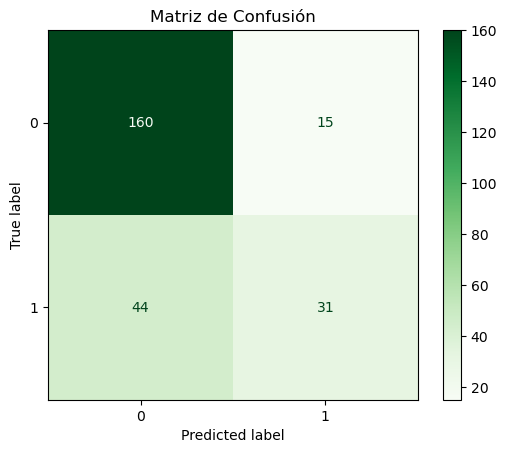

In [ ]:
#Generamos una matriz de confusión para cada genero asi despues podemos calcular si se cumplen los criterios de fairness
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predecir en conjunto de prueba
y_pred = best_clf.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión con etiquetas y colores
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Matriz de Confusión')
plt.show()


# Evaluación de equidad del modelo inicial

## Interpretacion de los criterios Fairness

En el contexto de la asignación de prestamos, después de ver los datos, consideramos como grupos de interés para buscar la equidad a las mujeres y los hombres, aunque también se podría considerar un grupo cada franja de edades. Siendo esos los grupos que nos interesan, en este contexto interpretamos los criterios de fairness de la siguiente manera: 

- *Statistical Parity*:
Este criterio se cumple si para todos los grupos la taza de predicciones positivas es la misma, lo que en este contexto significa que tanto para hombres como para mujeres se debería tener la misma probabilidad de conseguir que el modelo los clasifique como un buen credito y en consecuencia el banco les de el dinero.

- *Equalized Odds*:
En el caso de este criterio se busca que la probabilidad de que se apruebe el credito dado que era un buen credito y la probabilidad de que se apruebe el credito siendo que en la realidad era un mal credito sean las mismas entre los grupos. Esto se traduce en que se busca que para hombres y mujeres exista  la misma probabilidad de conseguir un prestamo dado que realmente es un buen credito, y la misma probabilidad de obtenerlo dado que no es un buen credito. Se espera que para las asignaciones de prestamos el modelo acierte y se equivoque con la misma taza entre grupos.

- *Equal Opportunity*:
Para este contexto implica que para hombres y mujeres exista la misma probabilidad de conseguir un préstamo dado que realmente es un buen credito. Solo mira los True Positive Rate. 

- *Predictive Parity*:
Este criterio se cumple cuando entre los grupos de interés la probabilidad de que en la realidad sea positivo dado que la predicción es positiva es la misma o similar. En el contexto de los prestamos se traduce buscando que si el modelo aprueba un credito, la probabilidad de que realmente sea un buen credito sea la misma tanto para mujeres como para hombres, es decir que la taza de prestamos aprobados correctamente sea similar.

## Analisis de Criterios

Primero separemos los datos utiles

In [131]:
data = X_test[['sexo_female']].copy() 
data['sexo'] = data['sexo_female'].map({1: 'female', 0: 'male'})
data['real'] = Y
data['predicho'] = y_pred2
data.drop('sexo_female', axis=1, inplace=True)

Definamos funciones utiles

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def TP(df):
    # Verdaderos positivos (TP): real=1, predicho=1
    return ((df['real'] == 1) & (df['predicho'] == 1)).sum()
def TN(df):
    # Verdaderos negativos (TN): real=2, predicho=2
    return ((df['real'] == 2) & (df['predicho'] == 2)).sum()
def FP(df):
    # Falsos positivos (FP): real=1, predicho=2
    return ((df['real'] == 2) & (df['predicho'] == 1)).sum()
def FN(df):
    # Falsos negativos (FN): real=1, predicho=2
    return ((df['real'] == 1) & (df['predicho'] == 2)).sum()

def SP(df):
    """Statistical Parity: Calcula la la proporción de predicciones positivas dentro de un grupo."""
    return (TP(df) + FP(df))/(TP(df) + TN(df) + FP(df) + FN(df))

def TPR(df):
    """Calcula la tasa de verdaderos positivos (TPR, recall)."""
    return TP(df) / (TP(df) + FN(df))

def FPR(df):
    """Calcula la tasa de falsos positivos (FPR)."""
    return FP(df) / (FP(df) + TN(df))

def PPV(df):
    """Calcula el valor predictivo positivo (PPV, precisión)."""
    return TP(df) / (TP(df) + FP(df))

def matriz_confusion(df, title=''):
    conf_matrix = np.array([
        [TP(df), FP(df)],
        [FN(df), TN(df)]
    ])

    # Muestra la matriz como gráfico
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicho 1', 'Predicho 2'],
                yticklabels=['Real 1', 'Real 2'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión {title}')
    plt.show()

Separemos los grupos de los datos en df diferentes

In [141]:
hombres = data[data['sexo'] == 'male'][['real', 'predicho']]
mujeres = data[data['sexo'] == 'female'][['real', 'predicho']]

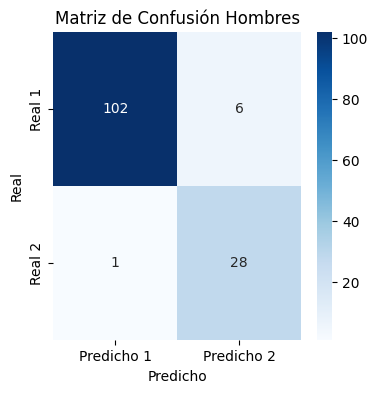

In [142]:
matriz_confusion(hombres, 'Hombres')

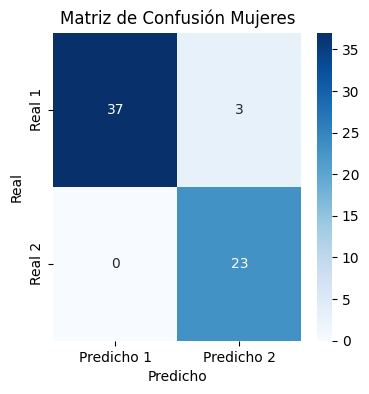

In [143]:
matriz_confusion(mujeres, 'Mujeres')

Calculamos los valores para cada grupo

In [145]:
# Para hombres
tasa_hombres = SP(hombres)
tpr_hombres = TPR(hombres)
fpr_hombres = FPR(hombres)
ppv_hombres = PPV(hombres)

# Para mujeres
tasa_mujeres = SP(mujeres)
tpr_mujeres = TPR(mujeres)
fpr_mujeres = FPR(mujeres)
ppv_mujeres = PPV(mujeres)

In [149]:
umbral = 0.05

print("="*15 + "Statistical Parity".upper() + "="*15)
# Statistical Parity
disp_stat_parity = abs(tasa_hombres - tasa_mujeres)
print(f"Disparidad Statistical Parity: {disp_stat_parity:.4f}")
print("¿Es fair? ", "Sí" if disp_stat_parity <= umbral else "No")

print("="*15 + "Equal Opportunity".upper() + "="*15)
disp_tpr = abs(tpr_hombres - tpr_mujeres)
print(f"Disparidad TPR (Equal Opportunity): {disp_tpr:.4f}")
print("¿Es fair? ", "Sí" if disp_tpr <= umbral else "No")

print("="*15 + "Equalized Odds".upper() + "="*15)
disp_fpr = abs(fpr_hombres - fpr_mujeres)
print(f"Disparidad TPR: {disp_tpr:.4f}")
print(f"Disparidad FPR: {disp_fpr:.4f}")
print("¿Es fair? ", "Sí" if (disp_tpr <= umbral and disp_fpr <= umbral) else "No")

print("="*15 + "Predictive Parity".upper() + "="*15)
# Predictive Parity (PPV)
disp_ppv = abs(ppv_hombres - ppv_mujeres)
print(f"Disparidad Predictive Parity: {disp_ppv:.4f}")
print("¿Es fair? ", "Sí" if disp_ppv <= umbral else "No")


===============STATISTICAL PARITY===============
Disparidad Statistical Parity: 0.1534
¿Es fair?  No
===============EQUAL OPPORTUNITY===============
Disparidad TPR (Equal Opportunity): 0.0097
¿Es fair?  Sí
===============EQUALIZED ODDS===============
Disparidad TPR: 0.0097
Disparidad FPR: 0.0611
¿Es fair?  No
===============PREDICTIVE PARITY===============
Disparidad Predictive Parity: 0.0194
¿Es fair?  Sí


## Justificacion del criterio relevante



Desde el punto de vista del banco, **maximizar el número de personas que pagan** implica evitar tanto errores de aprobar a quienes no pagarán (falsos positivos, FPR) como de rechazar a quienes sí pagarían (falsos negativos, FN). Sin embargo, el **error más grave** para el banco suele ser **aprobar a quienes no pagarán** (falsos positivos), porque esto implica pérdidas financieras directas.

Al mismo tiempo, **el banco debe asegurar que no discrimine por género** en la concesión de créditos, tanto por razones éticas como legales.

Por lo tanto, **el criterio más relevante es Equalized Odds** porque:
- **Protege la equidad:** Garantiza que el modelo no discrimine en las tasas de error (ni en falsos positivos ni en verdaderos positivos).
- **Protege la rentabilidad:** Al controlar los falsos positivos (personas que no pagan y son aprobadas), el banco minimiza las pérdidas.
- **Es más exigente que Statistical Parity:** No solo busca igualdad en la aprobación, sino también en la calidad de la decisión.
